In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sys
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import matplotlib_funs as mpf
import graph_funs as grf
import numerical_funs as nf
import general_funs as gef
import optics_funs as of
import finesse3_funs as f3f
import LCT_funs as lctf

import finesse
import finesse.ligo

import networkx as nx

In [776]:
code = '''
laser L0 P=125

s sin L0.p1 BS.p1
bs BS R=0.5 T=0.5 alpha=45 phi=0
s LX BS.p3 ETMX.p1 L=4e3
s LY BS.p2 ETMY.p1 L=4e3
m ETMX R=1 L=0 phi=0
m ETMY R=1 L=0 phi=45

qnoised noise BS.p4.o
qnoised NSR BS.p4.o nsr=true
pd pdo BS.p4.o
pd1 AS1 BS.p4.o f=&fsig

sgen DARMx LX.h
sgen DARMy LY.h phase=180
fsig(1)
'''

steps = [10, 100000, 5001]

kat = finesse.Model()
kat.parse(code)
xaxis = finesse.analysis.actions.Xaxis(kat.fsig.f, 'lin', *steps)
# xaxis = finesse.analysis.actions.Xaxis(kat.ETMX.phi, 'lin', *[89, 91, 10])
out = kat.run(xaxis)

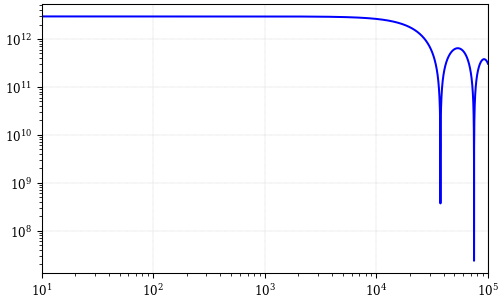

In [778]:
plt.loglog(out.x[0], np.abs(out['AS1']))

In [725]:
def michelson_amplitude(f_gw, L=10e3, lam0=1064e-9):
    c = 299792458
    w0 = c/lam0 * 2*np.pi
    tau = 2*L/c
    w_gw = 2*np.pi*f_gw
    return 2*w0/w_gw * np.abs(np.sin(w_gw*tau/2))

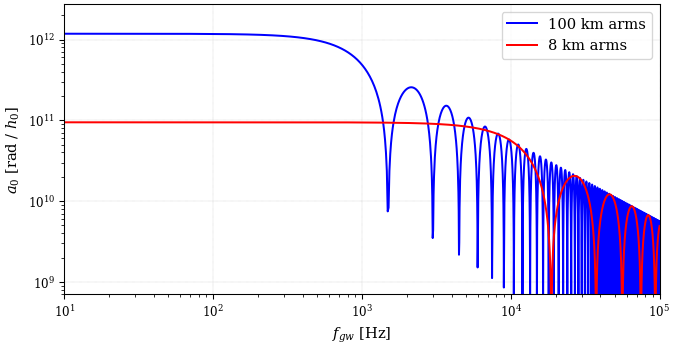

In [770]:
L = kat.LX.L.value
lam0 = 1064e-9
fs = out.x[0]

fig = plt.figure(figsize=[8,4])
plt.loglog(fs,michelson_amplitude(fs, L=100e3, lam0=lam0), label='100 km arms')
plt.loglog(fs,michelson_amplitude(fs, L=8e3, lam0=lam0), label='8 km arms')
plt.ylim([7e8,None])
plt.ylabel('$a_0$ [rad / $h_0$]')
plt.xlabel('$f_{gw}$ [Hz]')
plt.legend()

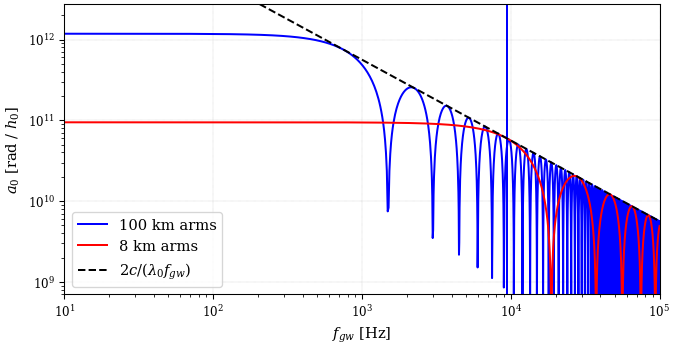

In [763]:
L = kat.LX.L.value
lam0 = 1064e-9
fs = out.x[0]

fig = plt.figure(figsize=[8,4])
plt.loglog(fs,michelson_amplitude(fs, L=100e3, lam0=lam0), label='100 km arms')
plt.loglog(fs,michelson_amplitude(fs, L=8e3, lam0=lam0), label='8 km arms')
plt.ylim([7e8,None])
plt.ylabel('$a_0$ [rad / $h_0$]')
plt.xlabel('$f_{gw}$ [Hz]')
plt.axvline(0.5*c/(2*8e3))
plt.loglog(fs, 2*c/(lam0*fs), ls='--', label=r'$2c / (\lambda_0 f_{gw})$')
plt.legend()

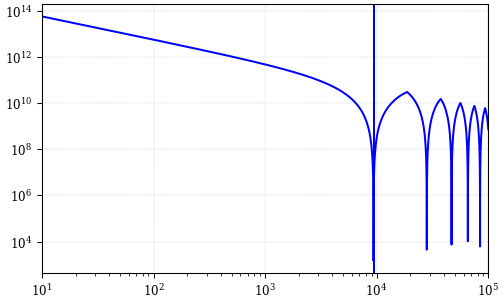

In [753]:
plt.loglog(fs, np.abs(michelson_amplitude(fs, L=8e3, lam0=lam0) - w0/(np.pi*fs)))
plt.axvline(0.5*c/(2*8e3))

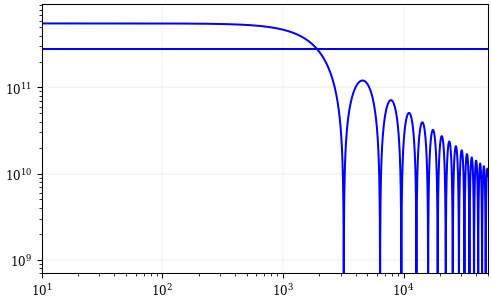

In [707]:
L = kat.LX.L.value
L= 47e3
c = 299792458
lam0 = 1064e-9
w0 = c/lam0 * 2* np.pi
# fs = np.linspace(10,3000,1001)
fs = out.x[0]
ws = 2*np.pi*fs
tau = 2*L/c

a1 = np.abs(np.sin(ws*tau)/(ws)) * k*c/2
a_toyra = np.sin(L*ws/c)/ws
a_bond = np.abs(w/ws * np.sin(ws*L/c))
a4 = 2*k*L*np.abs(8*np.sin(ws*tau/2)/ws)/4
a5 = 2*w/ws * np.abs(np.sin(ws*tau/2))
# plt.plot(fs,np.abs(a_toyra))
plt.loglog(fs,a5)
plt.ylim([7e8,None])
plt.axhline(w0*tau/2)
# plt.axhline(w*tau/4)
# plt.loglog(fs,a_bond)

## Absolute maximum michelson sensitivity
$$ \Delta \phi_{max} = \frac{\omega_0}{\omega_{gw}}$$
$$ \Delta \phi_{max} = \frac{2 c}{\lambda_0 f_{gw}}$$

## The first frequency where Michelson reaches peak sensitvity
$$ f = \frac{c}{4 L} $$

## Michelson response 3dB corner frequency
* can't be solved analytically
* numerically the 3dB frequency is about
$$f_{3dB} = \frac{0.6305}{\tau}$$
$$f_{3dB} = \frac{0.3153 c}{L}$$

In [711]:
lam0 = 1064e-9
c = 299792458
w0 = c/lam0 * 2* np.pi
Ls = np.linspace(100, 1e5, 101)
taus = 2*Ls/c

solns = []
for L in Ls:
    tau = 2*L/c
    tf = lambda f: michelson_amplitude(f, L=L, lam0=lam0) - w0*tau/2
    soln = scipy.optimize.fsolve(tf, 0.6034/tau)
    solns.append(soln[0])

solns = np.array(solns)

print(np.mean(solns*taus))
print(np.std(solns*taus))

0.603354564402
1.05382922678e-16
